In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Downloading...
From (original): https://drive.google.com/uc?id=1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F
From (redirected): https://drive.google.com/uc?id=1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F&confirm=t&uuid=af8cf6dc-c8ee-4069-86d2-7d40d9e518a2
To: /kaggle/working/Thyroid_Dataset.zip
100%|██████████| 395M/395M [00:03<00:00, 128MB/s]  


Download complete.
Unzipping dataset...
Unzipping complete.
Creating Train/Test directories...
Directory structure created.
Splitting and moving files...
Data split complete. 2509 training samples, 1076 testing samples.
DataLoaders are ready.
Using device: cuda
\n--- Starting Training for U-Net ---
Epoch 1/25 -> Train Loss: 0.2937, Test Dice: 0.8767
  -> New best model saved with Dice score: 0.8767
Epoch 2/25 -> Train Loss: 0.1886, Test Dice: 0.9047
  -> New best model saved with Dice score: 0.9047
Epoch 3/25 -> Train Loss: 0.1407, Test Dice: 0.9394
  -> New best model saved with Dice score: 0.9394
Epoch 4/25 -> Train Loss: 0.1073, Test Dice: 0.9490
  -> New best model saved with Dice score: 0.9490
Epoch 5/25 -> Train Loss: 0.0836, Test Dice: 0.9522
  -> New best model saved with Dice score: 0.9522
Epoch 6/25 -> Train Loss: 0.0665, Test Dice: 0.9612
  -> New best model saved with Dice score: 0.9612
Epoch 7/25 -> Train Loss: 0.0549, Test Dice: 0.9589
Epoch 8/25 -> Train Loss: 0.0456, Te

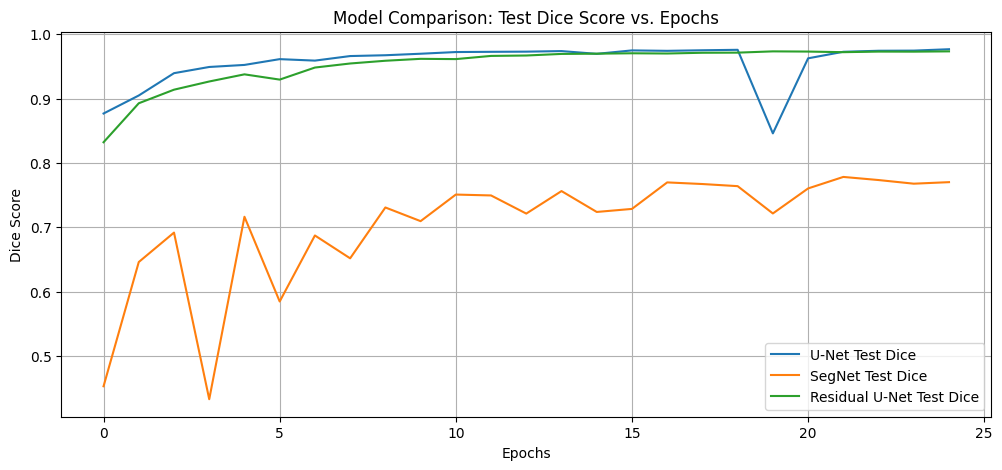

\nVisualizing predictions for each model...


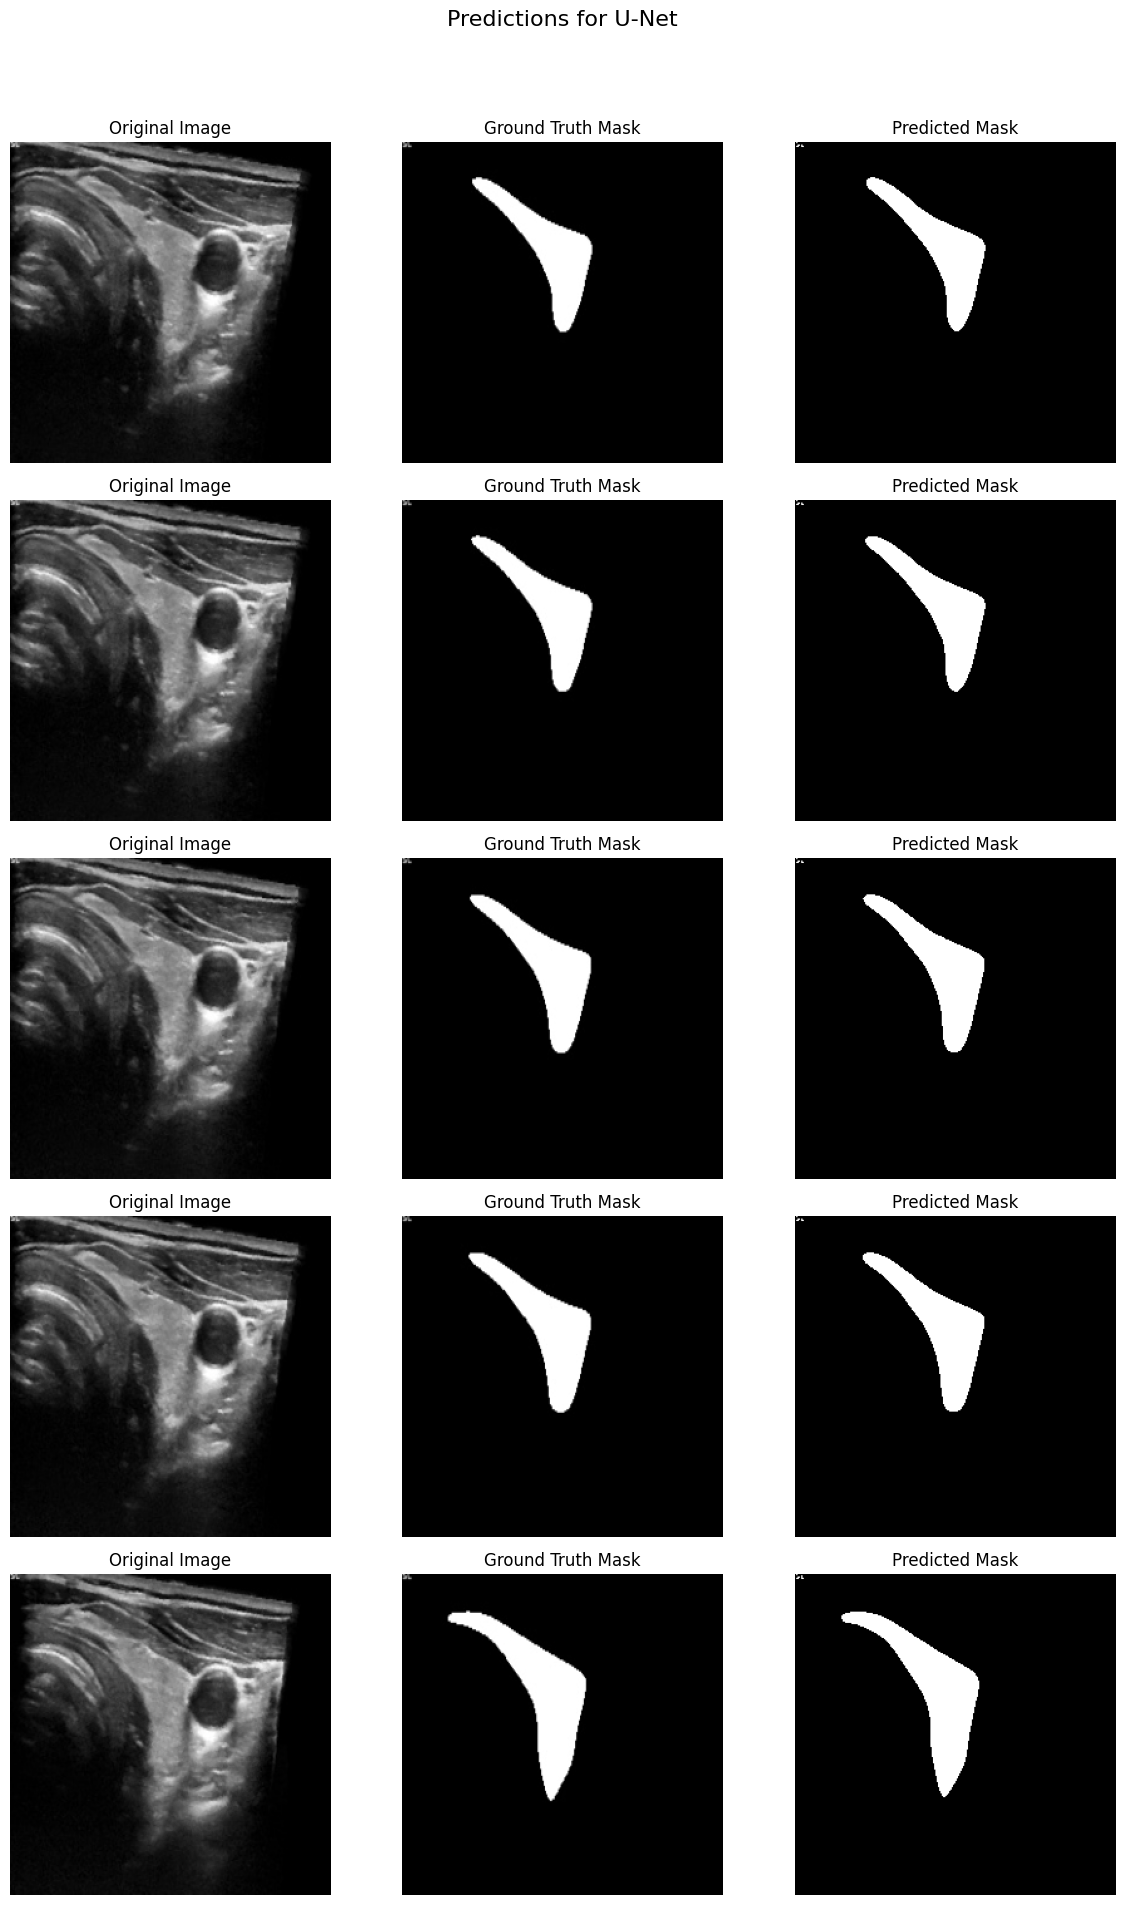

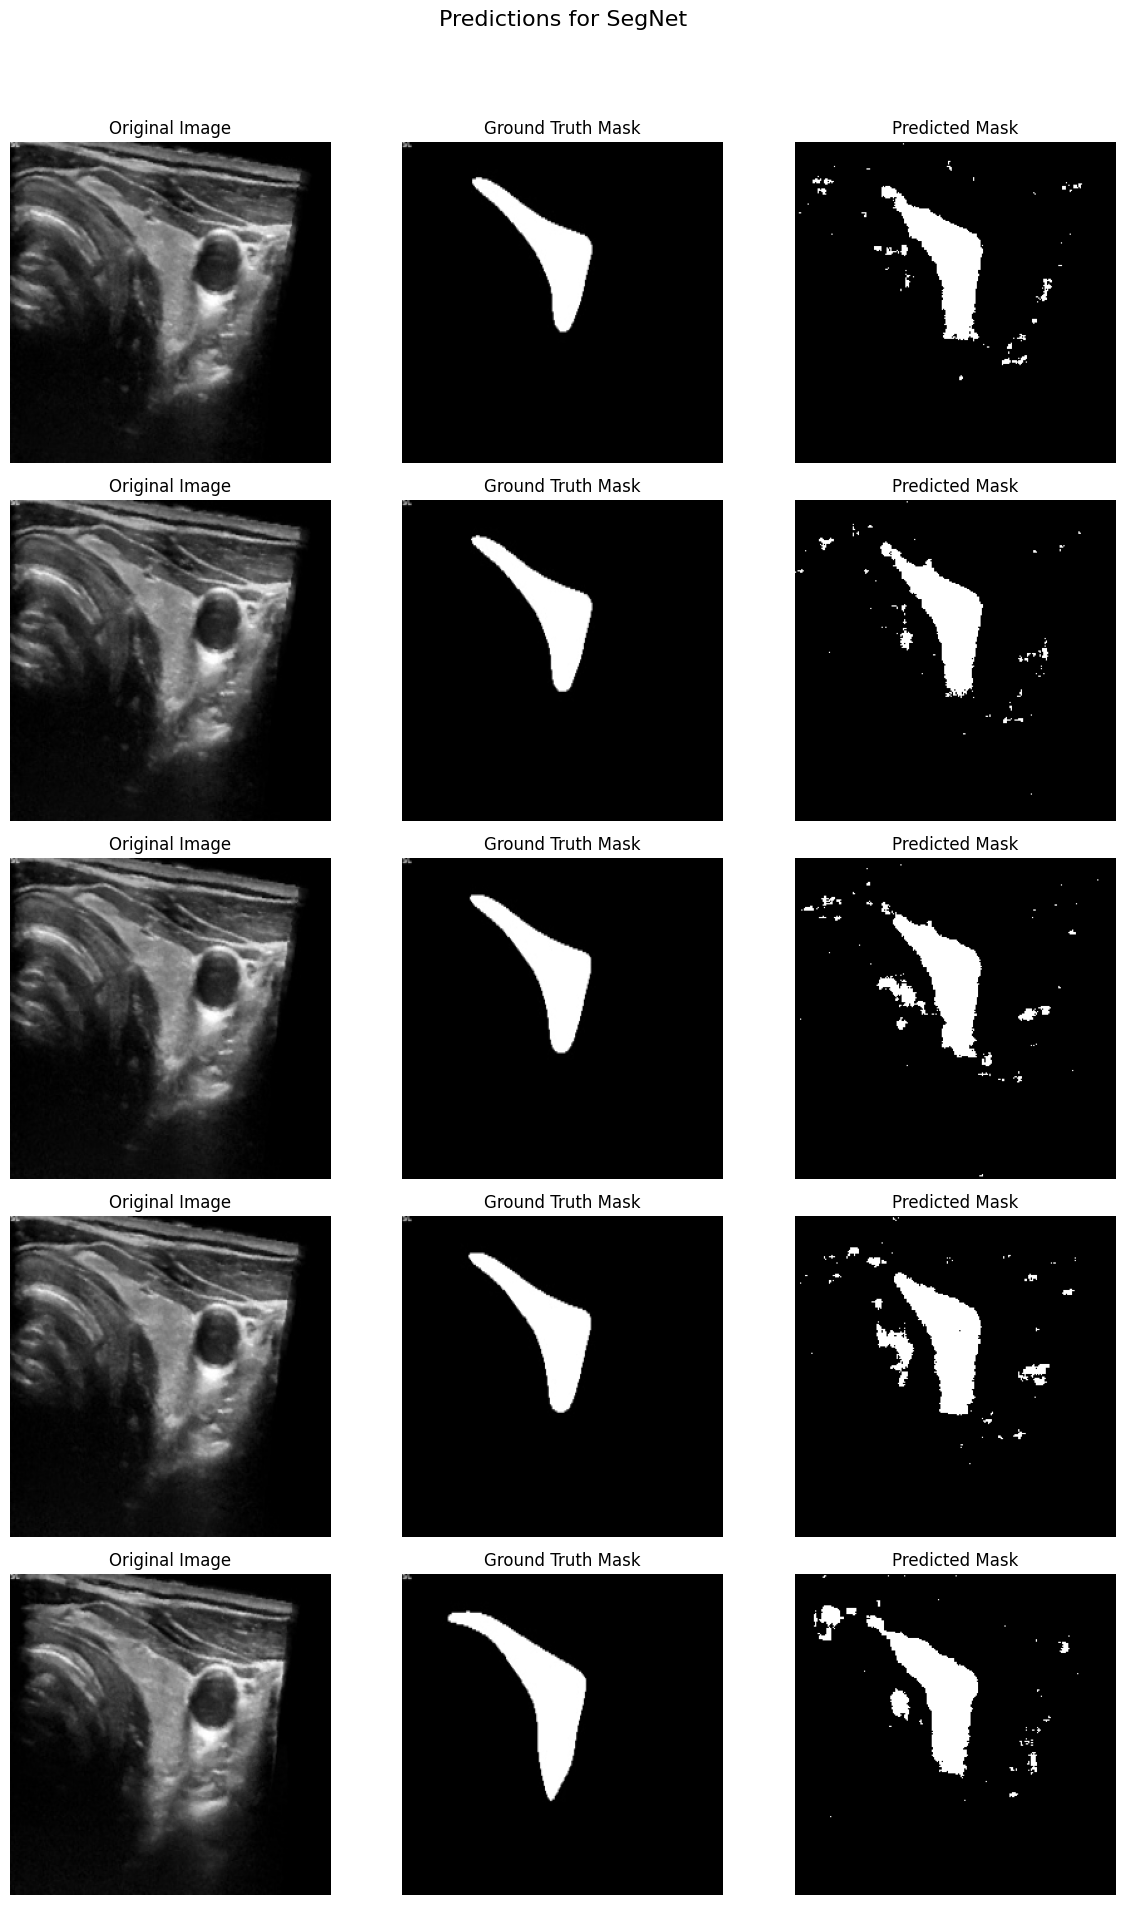

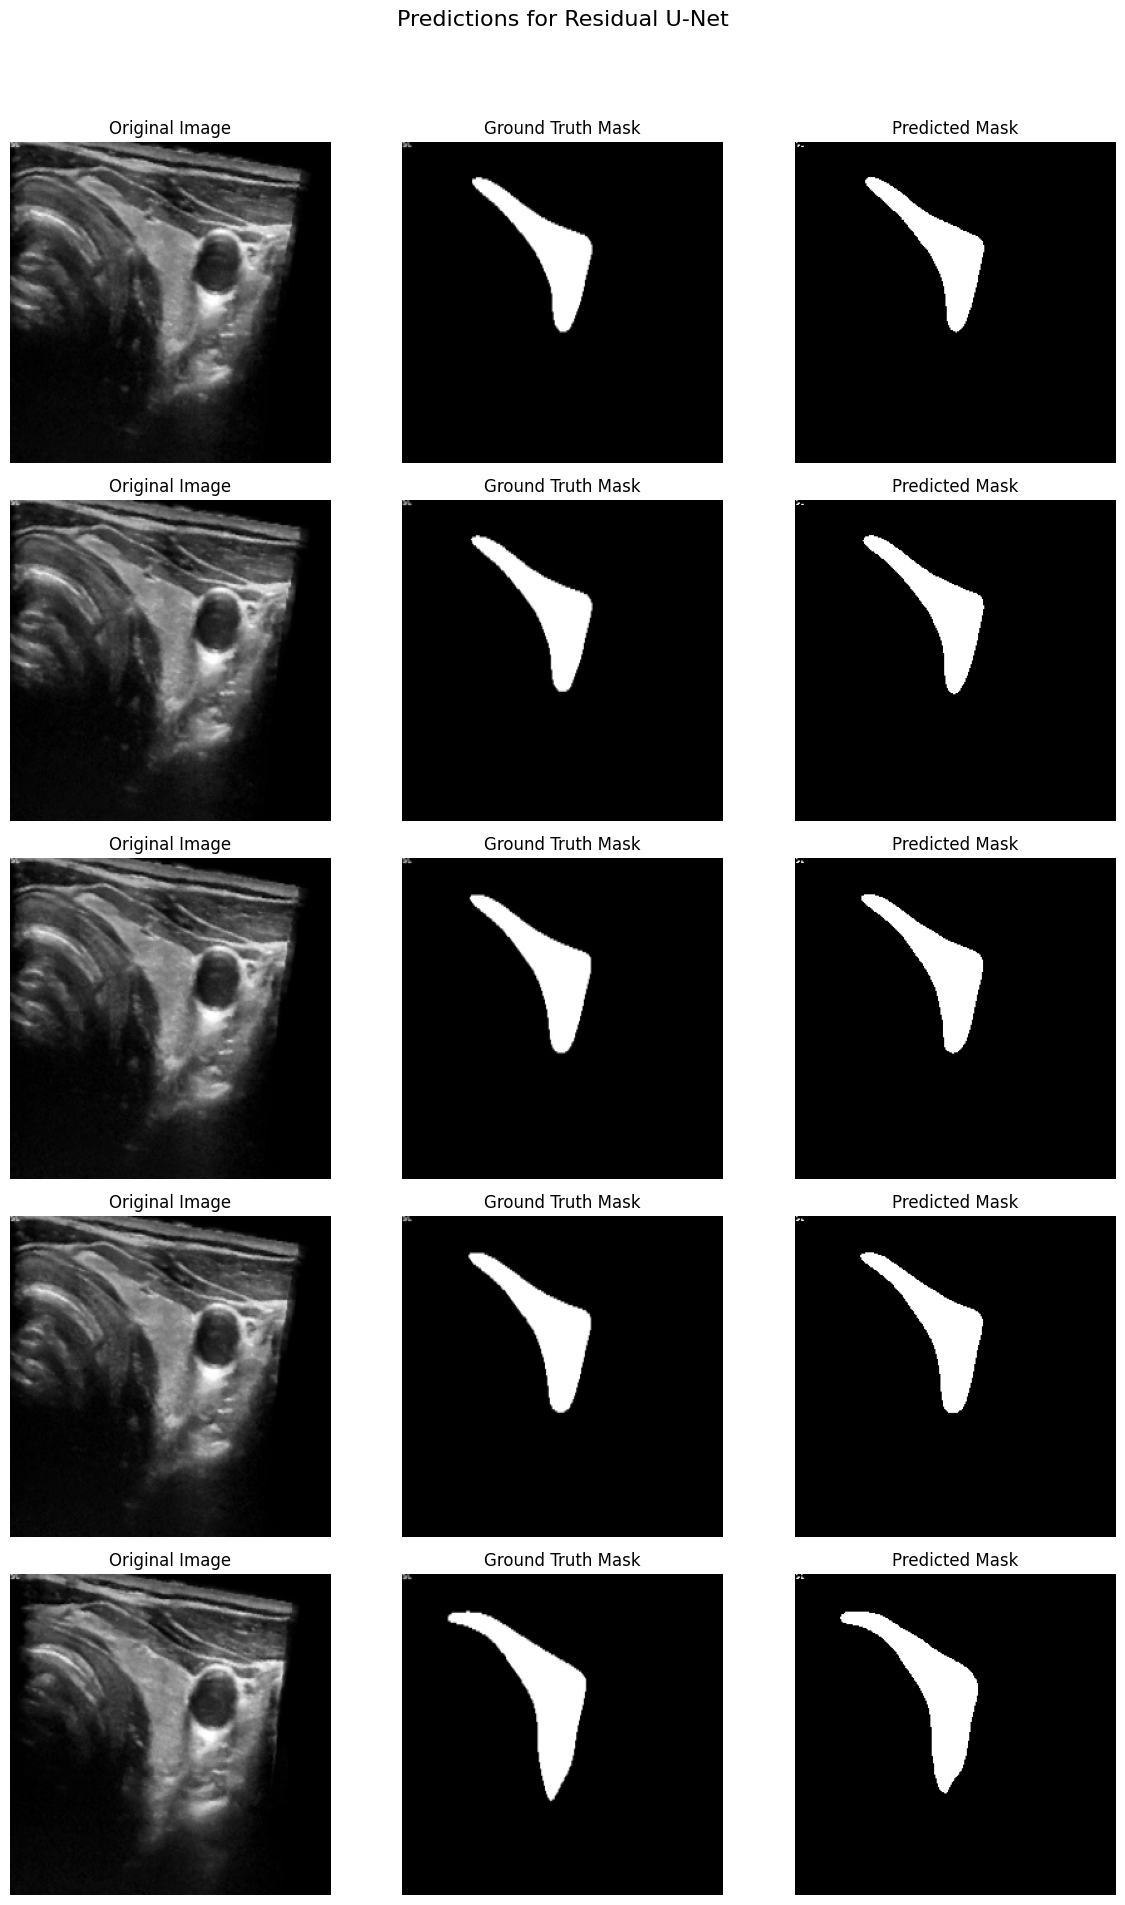

In [1]:
#
# --------------------------------------------------------------------------------
# S T E P  1 :  S E T U P  A N D  I M P O R T S
# --------------------------------------------------------------------------------
#
# Import all the necessary libraries for the project.
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import shutil
import numpy as np
import gdown
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

#
# --------------------------------------------------------------------------------
# S T E P  2 :  D A T A  P R E P A R A T I O N
# --------------------------------------------------------------------------------
#
# This section handles downloading the dataset, unzipping it, and splitting
# it into training and testing sets.

# --- Download the dataset from Google Drive ---
print("Downloading dataset...")
# The Google Drive file ID for the Thyroid Dataset
file_id = '1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F'
output_zip_path = 'Thyroid_Dataset.zip'
gdown.download(id=file_id, output=output_zip_path, quiet=False)
print("Download complete.")

# --- Unzip the dataset ---
print("Unzipping dataset...")
with ZipFile(output_zip_path, 'r') as zip_ref:
    zip_ref.extractall('Thyroid_Data')
print("Unzipping complete.")

# --- Create directory structure ---
print("Creating Train/Test directories...")
# Define base paths
base_path = 'data'
train_path = os.path.join(base_path, 'Train')
test_path = os.path.join(base_path, 'Test')

# Create directories, removing old ones if they exist
if os.path.exists(base_path):
    shutil.rmtree(base_path)

os.makedirs(os.path.join(train_path, 'Images'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'Masks'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Images'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Masks'), exist_ok=True)
print("Directory structure created.")


# --- Split data into Train and Test sets ---
# Define original data paths
path_img_folder = 'Thyroid_Data/Thyroid Dataset/tg3k/thyroid-image/'
path_mask_folder = 'Thyroid_Data/Thyroid Dataset/tg3k/thyroid-mask/'

image_files = sorted(os.listdir(path_img_folder))
mask_files = sorted(os.listdir(path_mask_folder))

# Create a shuffled index for splitting
indices = list(range(len(image_files)))
np.random.shuffle(indices)

# Define split point (e.g., 70% train, 30% test)
split_point = int(0.7 * len(image_files))
train_indices = indices[:split_point]
test_indices = indices[split_point:]

# Move files to the new directories
print("Splitting and moving files...")
for idx in train_indices:
    shutil.copy(os.path.join(path_img_folder, image_files[idx]), os.path.join(train_path, 'Images', image_files[idx]))
    shutil.copy(os.path.join(path_mask_folder, mask_files[idx]), os.path.join(train_path, 'Masks', mask_files[idx]))

for idx in test_indices:
    shutil.copy(os.path.join(path_img_folder, image_files[idx]), os.path.join(test_path, 'Images', image_files[idx]))
    shutil.copy(os.path.join(path_mask_folder, mask_files[idx]), os.path.join(test_path, 'Masks', mask_files[idx]))

print(f"Data split complete. {len(train_indices)} training samples, {len(test_indices)} testing samples.")

#
# --------------------------------------------------------------------------------
# S T E P  3 :  C O R R E C T E D  D A T A S E T  C L A S S  &  L O A D E R S
# --------------------------------------------------------------------------------
#
# This corrected class ensures that images and masks are paired correctly.

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # Create sorted lists of image and mask filenames
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Use the separate lists to get the correct image and mask paths
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Load image and mask in grayscale format
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# --- Define Transforms and Create DataLoaders ---
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SegmentationDataset(
    image_dir=os.path.join(train_path, 'Images'),
    mask_dir=os.path.join(train_path, 'Masks'),
    transform=data_transforms
)
test_dataset = SegmentationDataset(
    image_dir=os.path.join(test_path, 'Images'),
    mask_dir=os.path.join(test_path, 'Masks'),
    transform=data_transforms
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print("DataLoaders are ready.")

#
# --------------------------------------------------------------------------------
# S T E P  4 :  M O D E L  D E F I N I T I O N S
# --------------------------------------------------------------------------------
#
# All three architectures: U-Net, SegNet, and Residual U-Net.

# --- U-Net Architecture ---
class UNet(nn.Module):
    def __init__(self, n_classes=1):
        super(UNet, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        return torch.sigmoid(self.final_conv(dec1))

# --- SegNet Architecture ---
class SegNet(nn.Module):
    def __init__(self, n_classes=1):
        super(SegNet, self).__init__()
        self.enc_conv1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))
        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))
        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(True))
        self.dec_conv3 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(True))
        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))
        self.dec_conv1 = nn.Sequential(nn.Conv2d(64, n_classes, 3, padding=1), nn.BatchNorm2d(n_classes), nn.ReLU(True))

    def forward(self, x):
        x1 = self.enc_conv1(x)
        x, idx1 = F.max_pool2d(x1, 2, stride=2, return_indices=True)
        x2 = self.enc_conv2(x)
        x, idx2 = F.max_pool2d(x2, 2, stride=2, return_indices=True)
        x3 = self.enc_conv3(x)
        x, idx3 = F.max_pool2d(x3, 2, stride=2, return_indices=True)
        x = F.max_unpool2d(x, idx3, 2, stride=2)
        x = self.dec_conv3(x)
        x = F.max_unpool2d(x, idx2, 2, stride=2)
        x = self.dec_conv2(x)
        x = F.max_unpool2d(x, idx1, 2, stride=2)
        x = self.dec_conv1(x)
        return torch.sigmoid(x)

# --- Residual U-Net Architecture ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.shortcut is None else self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class UNetWithResiduals(nn.Module):
    def __init__(self, n_classes=1):
        super(UNetWithResiduals, self).__init__()
        self.enc1 = ResidualBlock(1, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.bottleneck = ResidualBlock(256, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(128, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        return torch.sigmoid(self.final_conv(dec1))

#
# --------------------------------------------------------------------------------
# S T E P  5 :  T R A I N I N G  S E T U P
# --------------------------------------------------------------------------------
#
# Helper functions for training, evaluation, and setting up the environment.

# --- GPU Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# --- Training and Evaluation Functions ---
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def dice_coefficient(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def evaluate_model(model, loader):
    model.eval()
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            outputs = model(images)
            total_dice += dice_coefficient(outputs, masks).item()
    return total_dice / len(loader)

#
# --------------------------------------------------------------------------------
# S T E P  6 :  M O D E L  T R A I N I N G  &  C O M P A R I S O N
# --------------------------------------------------------------------------------
#
# This block trains all three models sequentially and saves the best results.

# --- Initialize Models, Optimizers, and Loss Function ---
model_unet = UNet().to(device)
model_segnet = SegNet().to(device)
model_resunet = UNetWithResiduals().to(device)

optimizer_unet = torch.optim.Adam(model_unet.parameters(), lr=1e-4)
optimizer_segnet = torch.optim.Adam(model_segnet.parameters(), lr=1e-4)
optimizer_resunet = torch.optim.Adam(model_resunet.parameters(), lr=1e-4)

# Binary Cross Entropy is a good loss function for binary segmentation
criterion = nn.BCELoss()

# --- Main Training Loop ---
models = {
    "U-Net": (model_unet, optimizer_unet),
    "SegNet": (model_segnet, optimizer_segnet),
    "Residual U-Net": (model_resunet, optimizer_resunet)
}
histories = {name: {'train_loss': [], 'test_dice': []} for name in models.keys()}
num_epochs = 25 # Set number of epochs for training

for name, (model, optimizer) in models.items():
    print(f"\\n--- Starting Training for {name} ---")
    best_dice = 0.0
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_dice = evaluate_model(model, test_loader)
        
        histories[name]['train_loss'].append(train_loss)
        histories[name]['test_dice'].append(test_dice)
        
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Test Dice: {test_dice:.4f}")
        
        if test_dice > best_dice:
            best_dice = test_dice
            torch.save(model.state_dict(), f'best_{name.replace(" ", "_").lower()}_model.pth')
            print(f"  -> New best model saved with Dice score: {best_dice:.4f}")

print("\\nAll models have been trained.")

#
# --------------------------------------------------------------------------------
# S T E P  7 :  F I N A L  R E S U L T S  A N D  V I S U A L I Z A T I O N
# --------------------------------------------------------------------------------
#
# Compare final results and visualize the predictions.

# --- Load Best Models and Print Final Comparison ---
print("\\n--- Final Model Comparison on Test Set ---")
for name, (model, _) in models.items():
    model.load_state_dict(torch.load(f'best_{name.replace(" ", "_").lower()}_model.pth'))
    final_dice = evaluate_model(model, test_loader)
    print(f"{name}: {final_dice:.4f}")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))
for name in histories.keys():
    plt.plot(histories[name]['test_dice'], label=f'{name} Test Dice')
plt.title('Model Comparison: Test Dice Score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualize Predictions ---
def visualize_predictions(model, loader, model_name, num_images=5):
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = (outputs > 0.5).float()

    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    fig.suptitle(f'Predictions for {model_name}', fontsize=16)
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\\nVisualizing predictions for each model...")
for name, (model, _) in models.items():
    visualize_predictions(model, test_loader, name)
